### import pacakges

In [16]:
from tqdm import tqdm


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import os
import sys
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.init as init
from torch.autograd import Variable

from scipy.ndimage import rotate
from pretrained_models.resnet20 import ResNetCIFAR

from utils import *
from importlib import reload
reload(sys.modules['utils'])

2023-12-14 19:27:21.047400: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 19:27:21.047505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 19:27:21.455355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 19:27:22.253686: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 19:27:26.490776: W tensorflow/compiler/tf2

<module 'utils' from '/workspaces/Adversarial-Patches-Experimentation/10_code/utils.py'>

# prepare data

In [6]:
# PARAMS
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patch_size = 0.1
target = 1 #automobile

#CIFAR-10 image tensor mean and std
NORM_MEAN = [0.4914, 0.4822, 0.4465]
NORM_STD = [0.2023, 0.1994, 0.2010]




# TODO: should we apply the below transformations?
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

transform_image = transforms.ToPILImage()

print('==> Preparing data..')
trainset = torchvision.datasets.CIFAR10(root='../00_data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='../00_data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


### patch

In [7]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

In [8]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

In [39]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    n = 0 # number of images
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4):
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
                n += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    attack_success_rate = tp/n
    return acc, top5, attack_success_rate

In [43]:
def patch_attack(model, target_class, patch_size=10, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    train_set, val_set = torch.utils.data.random_split(trainset, [0.8, 0.2])
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last = True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")
        if epoch % 5 == 0:
            acc, top5, atttack_success_rate = eval_patch(model, patch, val_loader, target_class)
            print(f"Epoch {epoch}, Attack Success Rate: {atttack_success_rate.item():4.2f}")

    # Final validation
    # acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item(), "attack_success_rate": atttack_success_rate.item()}


In [46]:
# load the Pre-Trained ResNet-20 model
net = ResNetCIFAR(num_layers=20, Nbits=None)
net = net.to(device)
net.load_state_dict(torch.load("./pretrained_models/pretrained_model.pt"))

<All keys matched successfully>

In [47]:
p, x = patch_attack(net, target_class=8, patch_size=16, num_epochs=30)

Epoch 0, Attack Success Rate: 0.05


Epoch 5, Attack Success Rate: 0.98


Epoch 10, Attack Success Rate: 0.99


Epoch 15, Attack Success Rate: 0.99


Epoch 20, Attack Success Rate: 0.99


Epoch 25, Attack Success Rate: 0.99


In [24]:
# check test accuracy
eval_patch(net, p, testloader, target_class=8)

(tensor(0.0598, device='cuda:0'), tensor(0.4388, device='cuda:0'))

In [ ]:
# show patch
# plt.imshow(transform_image(patch_forward(p).cpu()))

In [52]:
p_ = (torch.tanh(p) + 1) / 2 # Parameter to pixel values
p_ = p_.cpu().permute(1, 2, 0).numpy()
p_ = np.clip(p_, a_min=0.0, a_max=1.0)

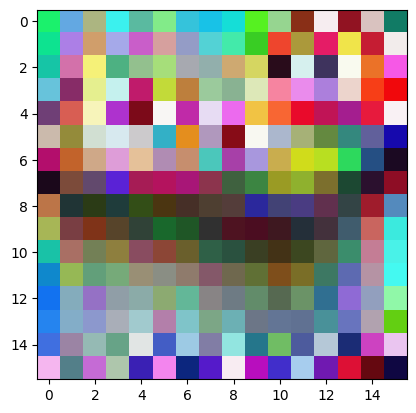

In [53]:
plt.imshow(p_)